## Exercise 1 - Culinary History

First name: Brian
<br>
Last name: Schweigler
<br>
Matriculation number: 16-102-071

##### Q1: Consider the function plot_trend() used in the lectures. Discover the two ingredients that appear more frequently in the 20th century and in the beginning of the 19th century.


General imports and set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_selection import chi2
import scipy


df = pd.read_csv("data/feeding-america.csv", index_col='date')
def plot_trend(column, df, line_color='grey', xlim=(1810, 1930)):
    slope, intercept, _, _, _ = scipy.stats.linregress(
    df.index, df[column].fillna(0).values)

    ax = df[column].plot(style='o', label=column)
    ax.plot(df.index, intercept + slope * df.index, '--',
    color=line_color, label='_nolegend_')
    ax.set_ylabel("fraction of recipes")
    ax.set_xlabel("year of publication")
    ax.set_xlim(xlim)

In the following, we will simply try to recreate some of the functions seen in the lecture.

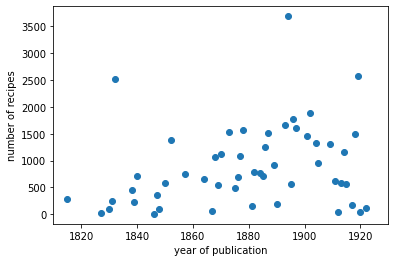

In [2]:
grouped = df.groupby('date')
recipe_counts = grouped.size()
recipe_counts.plot(style='o', xlim=(1810, 1930)) #<AxesSubplot:xlabel='date'> # plot the group size
plt.ylabel("number of recipes")
plt.xlabel("year of publication")
plt.show()

Next the grouping of ingredients with some different naming for clarity.

In [3]:
ingredients = df['ingredients'].str.split(';')
groups = ingredients.groupby(ingredients.keys())
ingredients_sum = groups.sum()
most_used_ingredients = ingredients_sum.max()
ingredients_per_annum = ingredients_sum.apply(pd.Series.value_counts)
ingredients_normalized = ingredients_per_annum.divide(recipe_counts, 0)

Going by the lecture, we can assume that both baking powder and tomato are the ones that see the sharpest increase in usage.

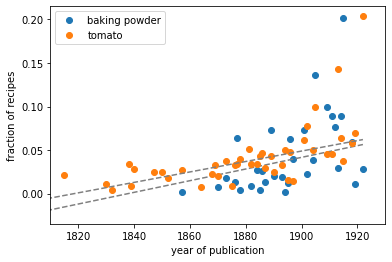

In [4]:
plot_trend('baking powder', ingredients_normalized)
plot_trend('tomato', ingredients_normalized)
plt.legend()
plt.show()

We could compare them to the three generally most used ones like water, currant jelly, and juice. (Gathered through most_used_ingredients)

Coincidentally, they remain quite constant in their usage.

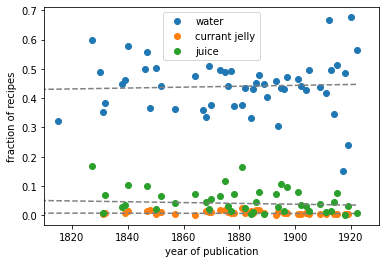

In [5]:
plot_trend('water', ingredients_normalized)
plot_trend('currant jelly', ingredients_normalized)
plot_trend('juice', ingredients_normalized)
plt.legend()
plt.show()

##### Q2: Can you compare the recipes appearing in books published between 1820-1840 with those from the period 1900–1920? Which are for you the main differences?


For this, we will simply aim to use the same chi2 statistic as used in the lecture, differentiating between the ranges.

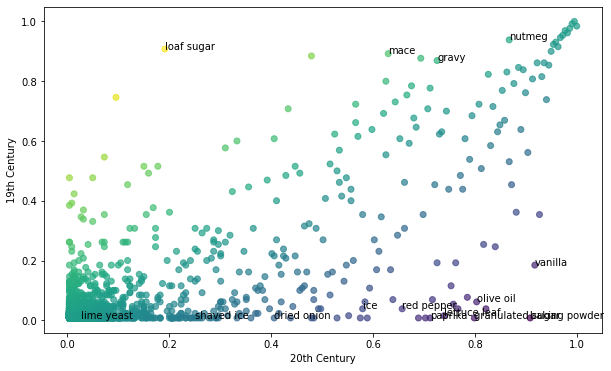

In [6]:
labels_18 = ['18th century' if 1819 < year < 1841 else 'Unused' for year in ingredients_normalized.index]
labels_19 = ['19th century' if 1899 < year < 1921 else 'Unused' for year in ingredients_normalized.index]

keyness, _ = chi2(ingredients_normalized.fillna(0), labels_18)
keyness_18 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)
keyness, _ = chi2(ingredients_normalized.fillna(0), labels_19)
keyness_19 = pd.Series(keyness, index=ingredients_normalized.columns).sort_values(ascending=False)

keyness_18.head(n=10)
keyness_19.head(n=10)

# Step 1: compute summed ingredient counts per year (in a matrix date x ingredients)
counts = df['ingredients'].str.split(';').groupby('date').sum().apply(pd.Series.value_counts).fillna(0)

# Step 2: construct two frequency rankings, one pre- and one post-war years

nineteenth_century=counts[np.logical_and(counts.index>1819, counts.index<1841)].sum().rank(method='dense', pct=True)
twentieth_century=counts[np.logical_and(counts.index>1899, counts.index<1921)] .sum().rank(method='dense', pct=True)

# Step 3: merge the 19th and 20th century dataframes resulting into two dataframes
rankings=pd.DataFrame({'19th Century': nineteenth_century, '20th Century': twentieth_century})

# Step 4: produce the plot
fig = plt.figure(figsize=(10, 6))
plt.xlabel("20th Century")
plt.ylabel("19th Century")
plt.scatter(rankings['20th Century'], rankings['19th Century'],
            c=rankings['19th Century']-rankings['20th Century'],
            alpha=0.7) # c = color

# Add annotations of the 20 most distinctive ingredients
for i, row in rankings.loc[keyness_19.head(15).index].iterrows():
    plt.annotate(i, xy=(row['20th Century'], row['19th Century']))
plt.show()

grouped = df.groupby(level='date')

Thus we can see that loaf sugar is more likely to be used in the 19th century than the 20th.

A lot of exotic ingredients like vanilla, olive oil, red pepper, paprika, and the baking powder mentioned in question 1 
are more likely in the new 20th century.